<a href="https://colab.research.google.com/github/Ase96/Geospatial_analysis_using_ML/blob/main/pyspark_stroke_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark -q

In [3]:
!pip install squarify

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
import squarify

from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.ml import Pipeline
from pyspark.sql import SQLContext
from pyspark.sql.functions import mean, col, split, regexp_extract, when, lit
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import roc_curve, auc
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Connect to Spark

In [5]:
spark = SparkSession.builder.appName('PySpark ML project').getOrCreate()

In [6]:
sc = spark.sparkContext.getOrCreate()

# Examine data

In [7]:
path = '../content/brain_stroke.csv'
df = spark.read.csv(path, header='True', inferSchema='True')
df.show(10)

+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
|Female|79.0|           1|            0|         Yes|Self-employed|         Rural|           174.12|24.0|   never smoked|     1|
|  Male|81.0|           0|            0|         Yes|      Private|         Urban|           186.

In [8]:
df.limit(10).toPandas()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
5,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
6,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
7,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1
8,Female,81.0,1,0,Yes,Private,Rural,80.43,29.7,never smoked,1
9,Female,61.0,0,1,Yes,Govt_job,Rural,120.46,36.8,smokes,1


In [9]:
df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [10]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|     0|  0|           0|            0|           0|        0|             0|                0|  0|             0|     0|
+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



## Convert dataframe to Pandas to enable Seaborn and Matplotlib

In [11]:
df_pd = df.toPandas()

df_pd.loc[(df_pd.stroke == 1), 'stroke']='Stroke'
df_pd.loc[(df_pd.stroke == 0), 'stroke']='No stroke'

df_pd.loc[(df_pd.heart_disease == 1), 'heart_disease']='Heart disease'
df_pd.loc[(df_pd.heart_disease == 0), 'heart_disease']='No heart disease'

df_pd.loc[(df_pd.hypertension == 1), 'hypertension']='Hypertension'
df_pd.loc[(df_pd.hypertension == 0), 'hypertension']='No hypertension'

<ipython-input-11-e245242e281b>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Stroke' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df_pd.loc[(df_pd.stroke == 1), 'stroke']='Stroke'
<ipython-input-11-e245242e281b>:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Heart disease' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df_pd.loc[(df_pd.heart_disease == 1), 'heart_disease']='Heart disease'
<ipython-input-11-e245242e281b>:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Hypertension' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df_pd.loc[(df_pd.hypertension == 1), 'hypertension']='Hypertension'


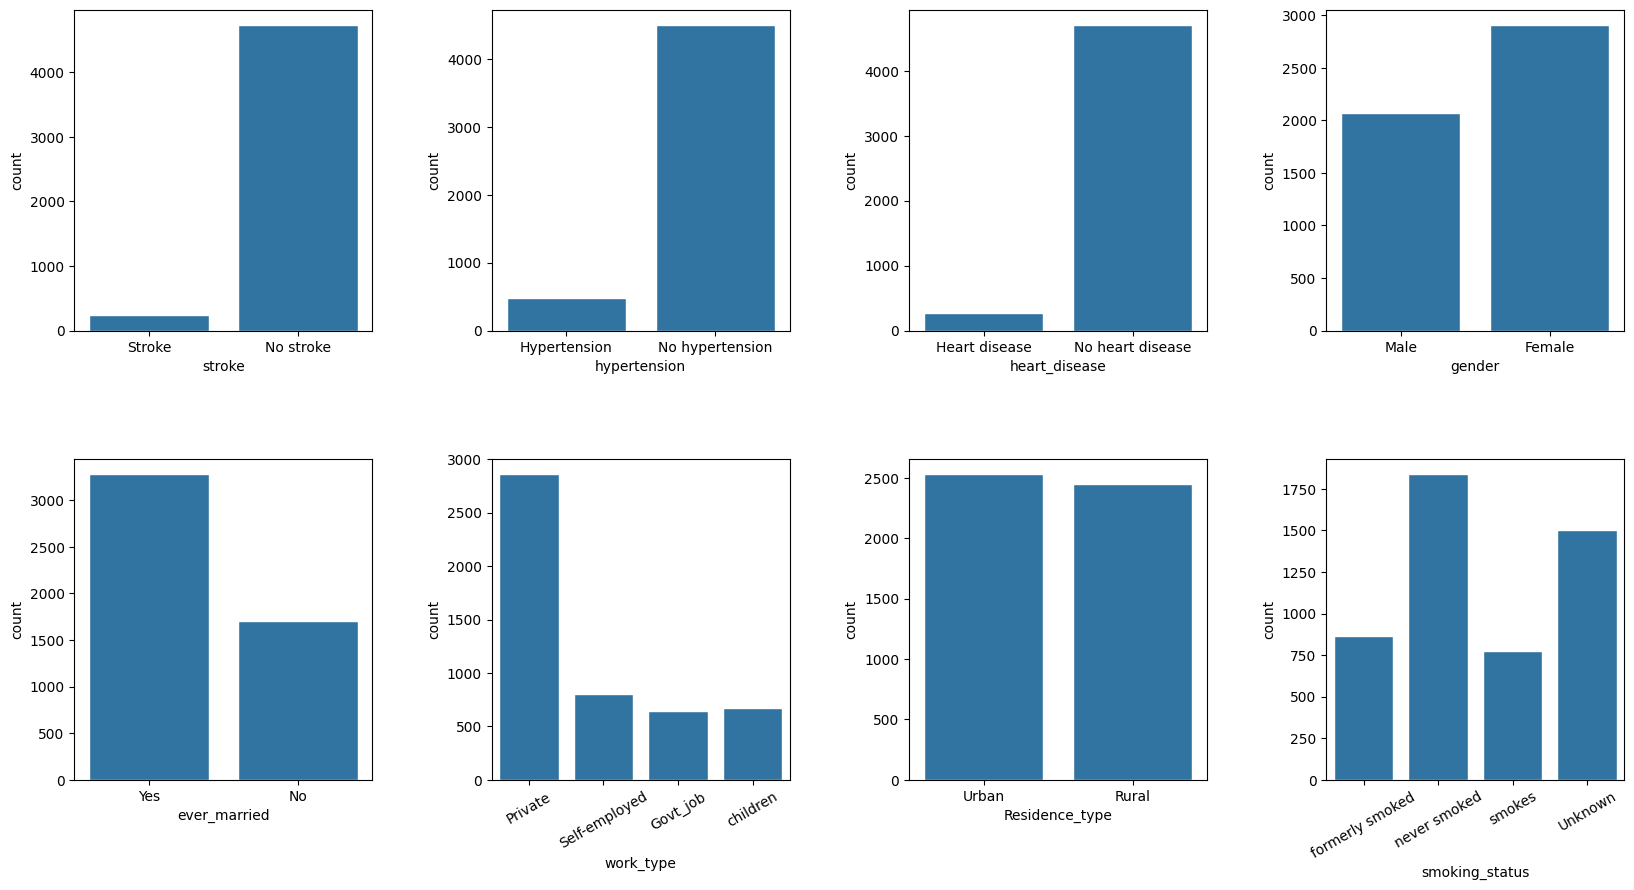

In [12]:
fig, axes = plt.subplots(2, 4, figsize=(20,10))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
sns.set_theme()

sns.countplot(data=df_pd, x='stroke', ax=axes[0,0])

sns.countplot(data=df_pd, x='hypertension', order=['Hypertension', 'No hypertension'], ax=axes[0,1])

sns.countplot(data=df_pd, x='heart_disease', ax=axes[0,2])

sns.countplot(data=df_pd, x='gender', ax=axes[0,3])

sns.countplot(data=df_pd, x='ever_married', ax=axes[1,0])

sns.countplot(data=df_pd, x='work_type', ax=axes[1,1])
axes[1,1].tick_params(axis='x', rotation=30)

sns.countplot(data=df_pd, x='Residence_type', ax=axes[1,2])

sns.countplot(data=df_pd, x='smoking_status', ax=axes[1,3])
axes[1,3].tick_params(axis='x', rotation=30)

<Axes: title={'center': 'BMI distribution'}, xlabel='bmi', ylabel='Count'>

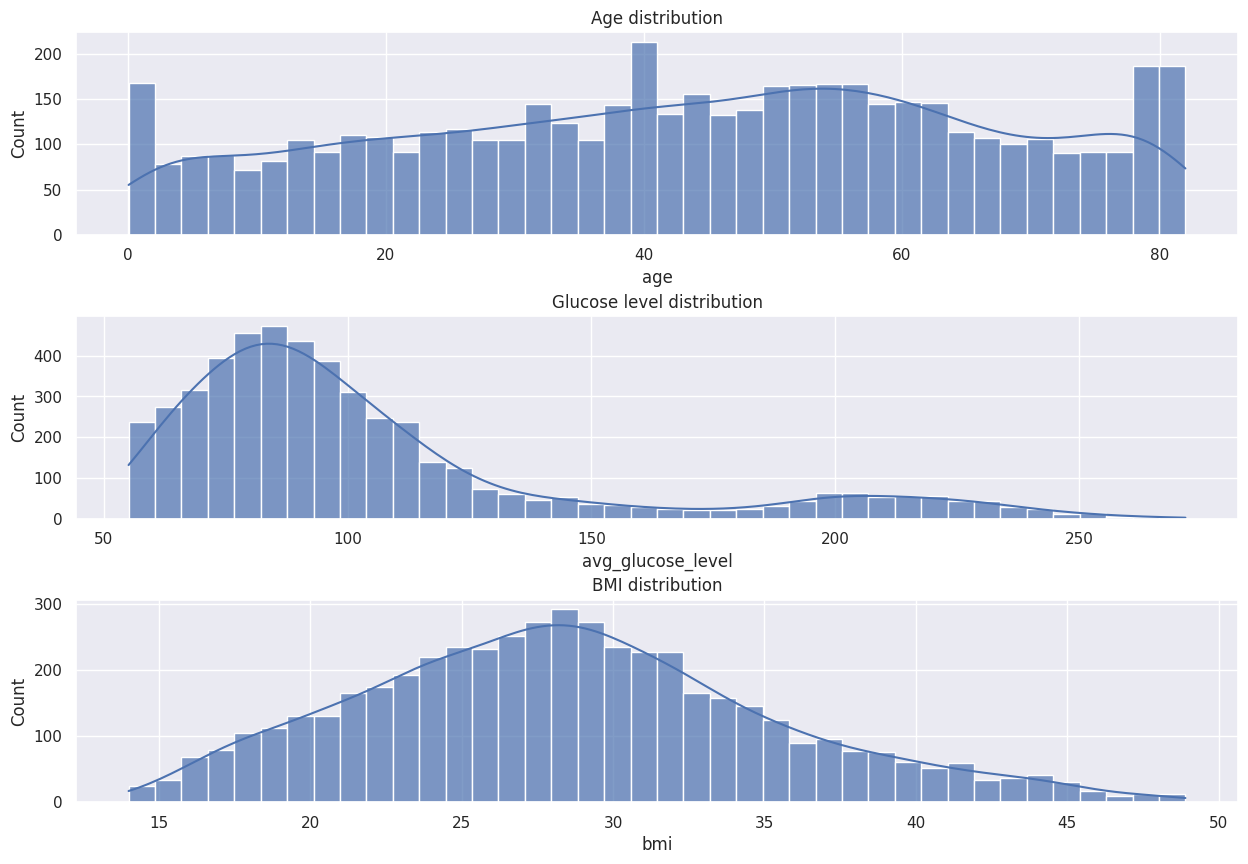

In [14]:
fig, axes = plt.subplots(3, 1, figsize=(15,10))
plt.subplots_adjust(hspace=0.4)
sns.set_theme()

axes[0].set_title('Age distribution')
sns.histplot(df_pd['age'], bins=40, kde=True, alpha=0.7, ax=axes[0])

axes[1].set_title('Glucose level distribution')
sns.histplot(df_pd['avg_glucose_level'], bins=40, kde=True, alpha=0.7, ax=axes[1])

axes[2].set_title('BMI distribution')
sns.histplot(df_pd['bmi'], bins=40, kde=True, alpha=0.7, ax=axes[2])

<Axes: xlabel='stroke', ylabel='bmi'>

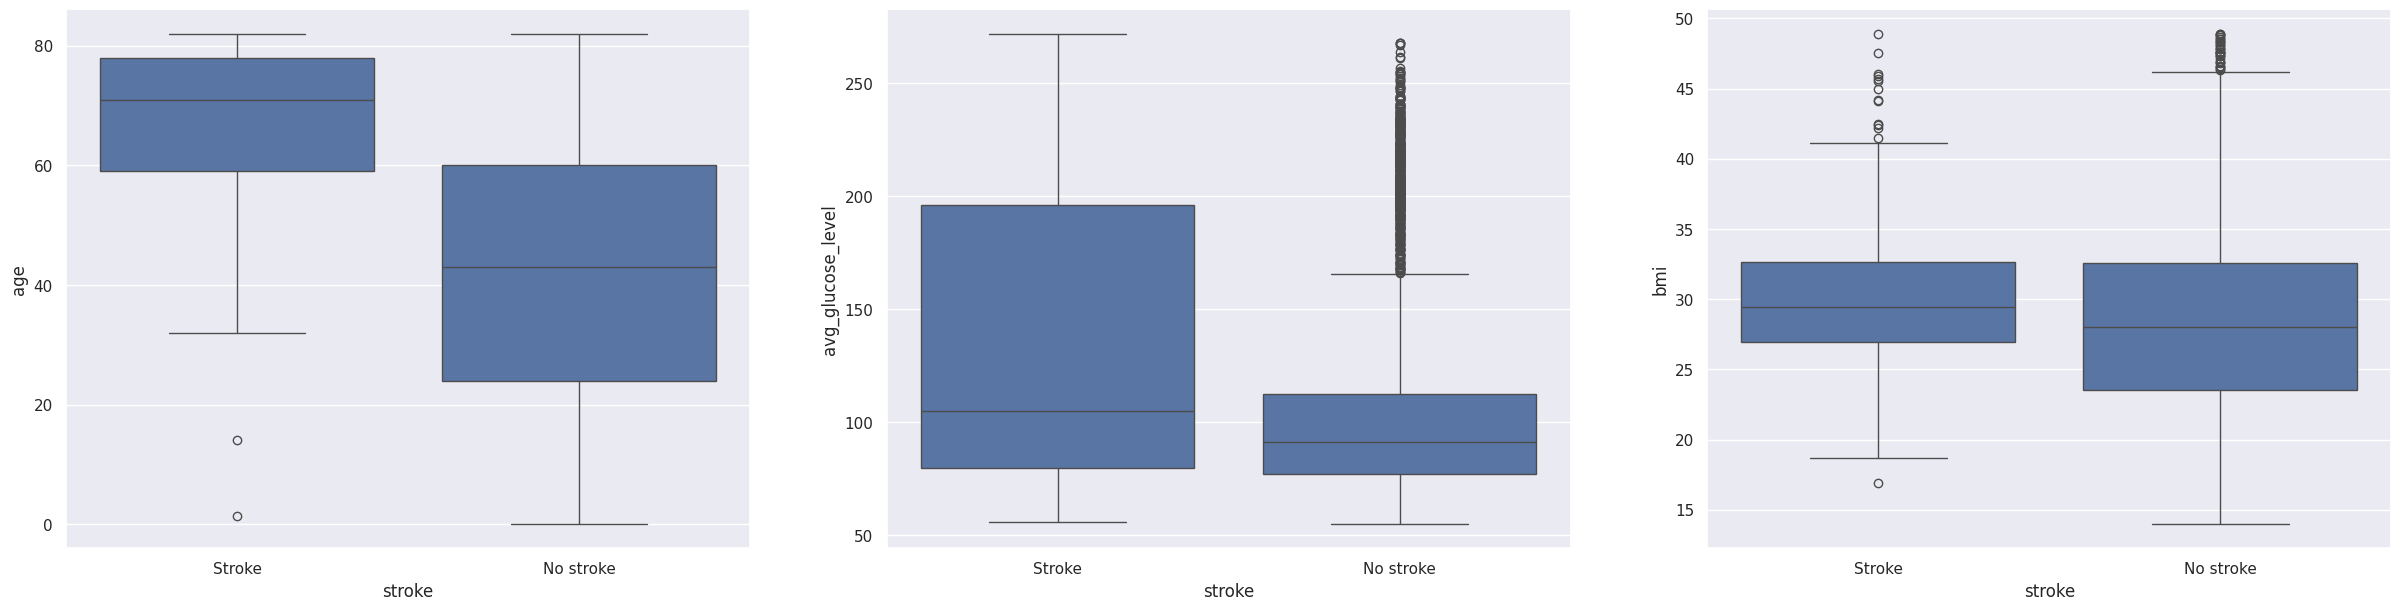

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(30,7))

sns.boxplot(data=df_pd, x='stroke', y='age', ax=axes[0])

sns.boxplot(data=df_pd, x='stroke', y='avg_glucose_level', ax=axes[1])

sns.boxplot(data=df_pd, x='stroke', y='bmi', ax=axes[2])

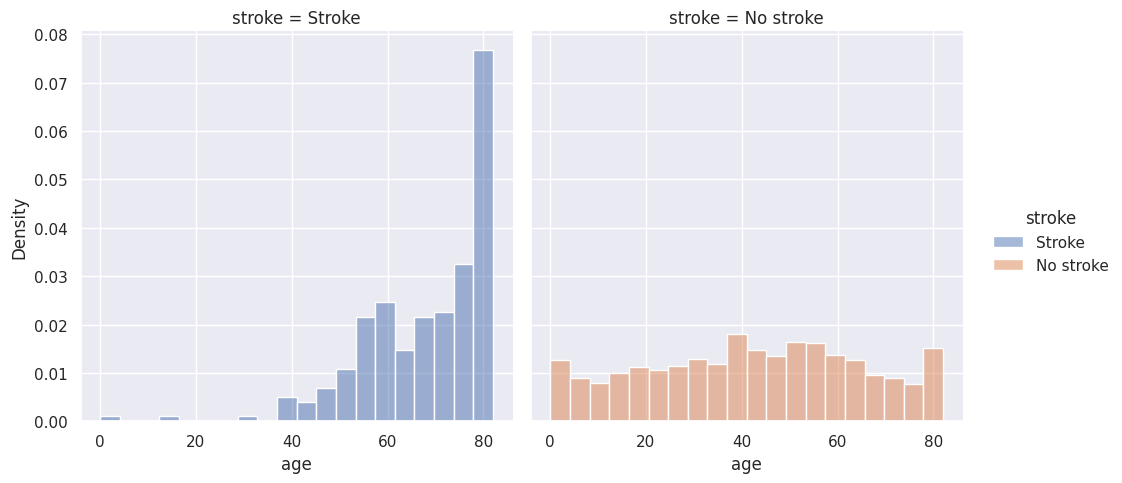

In [16]:
sns.displot(df_pd, x='age', hue='stroke', col='stroke', stat='density', common_norm=False)

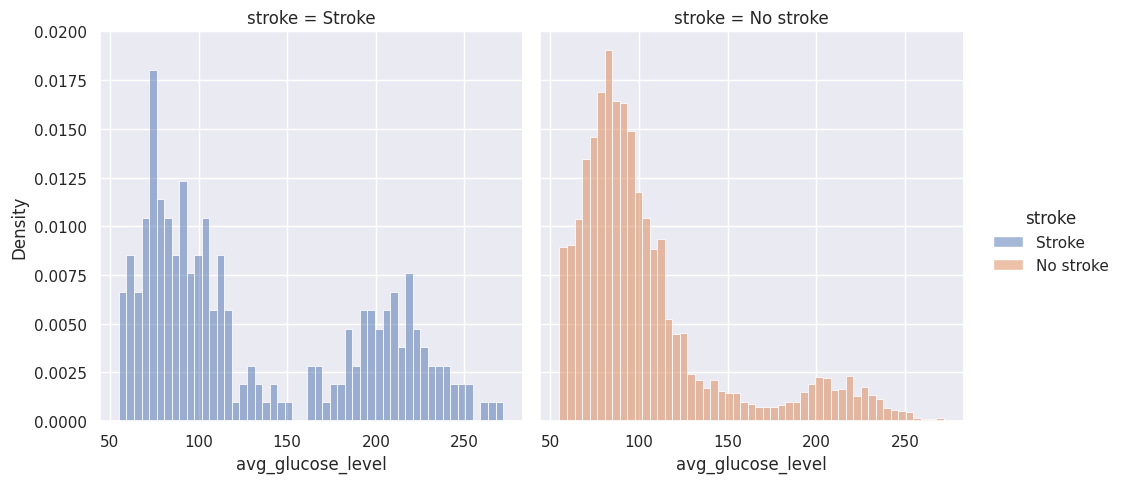

In [17]:
sns.displot(df_pd, x='avg_glucose_level', hue='stroke', col='stroke', stat='density', common_norm=False)

In [18]:
df = df.withColumn(
    'high_risk',
    when((col('age') >= 40) & (col("avg_glucose_level") <= 125), 1).otherwise(0))

df.show(3)

+------+----+------------+-------------+------------+---------+--------------+-----------------+----+---------------+------+---------+
|gender| age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|high_risk|
+------+----+------------+-------------+------------+---------+--------------+-----------------+----+---------------+------+---------+
|  Male|67.0|           0|            1|         Yes|  Private|         Urban|           228.69|36.6|formerly smoked|     1|        0|
|  Male|80.0|           0|            1|         Yes|  Private|         Rural|           105.92|32.5|   never smoked|     1|        1|
|Female|49.0|           0|            0|         Yes|  Private|         Urban|           171.23|34.4|         smokes|     1|        0|
+------+----+------------+-------------+------------+---------+--------------+-----------------+----+---------------+------+---------+
only showing top 3 rows



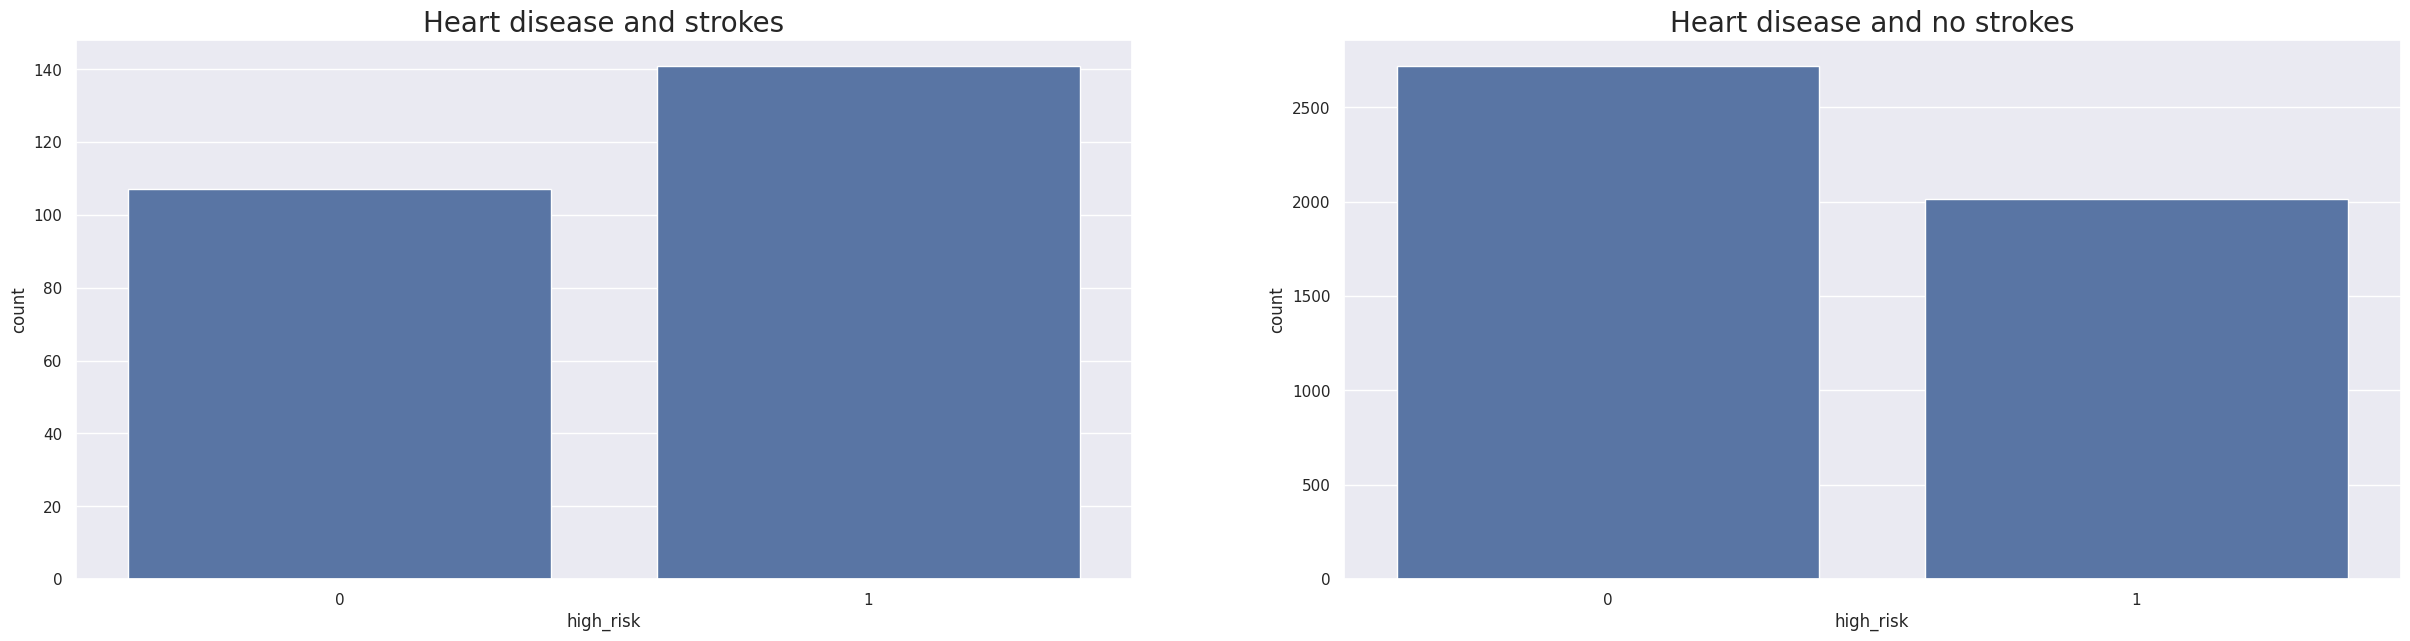

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(30,7))

axes[0].set_title('Heart disease and strokes', fontsize=20)
ax0 = sns.countplot(data=df.toPandas().loc[df_pd['stroke'] == 'Stroke'], x='high_risk', ax=axes[0])

axes[1].set_title('Heart disease and no strokes', fontsize=20)
ax1 = sns.countplot(data=df.toPandas().loc[df_pd['stroke'] == 'No stroke'], x='high_risk', ax=axes[1])

<Axes: title={'center': 'Gender and no strokes'}, xlabel='gender', ylabel='count'>

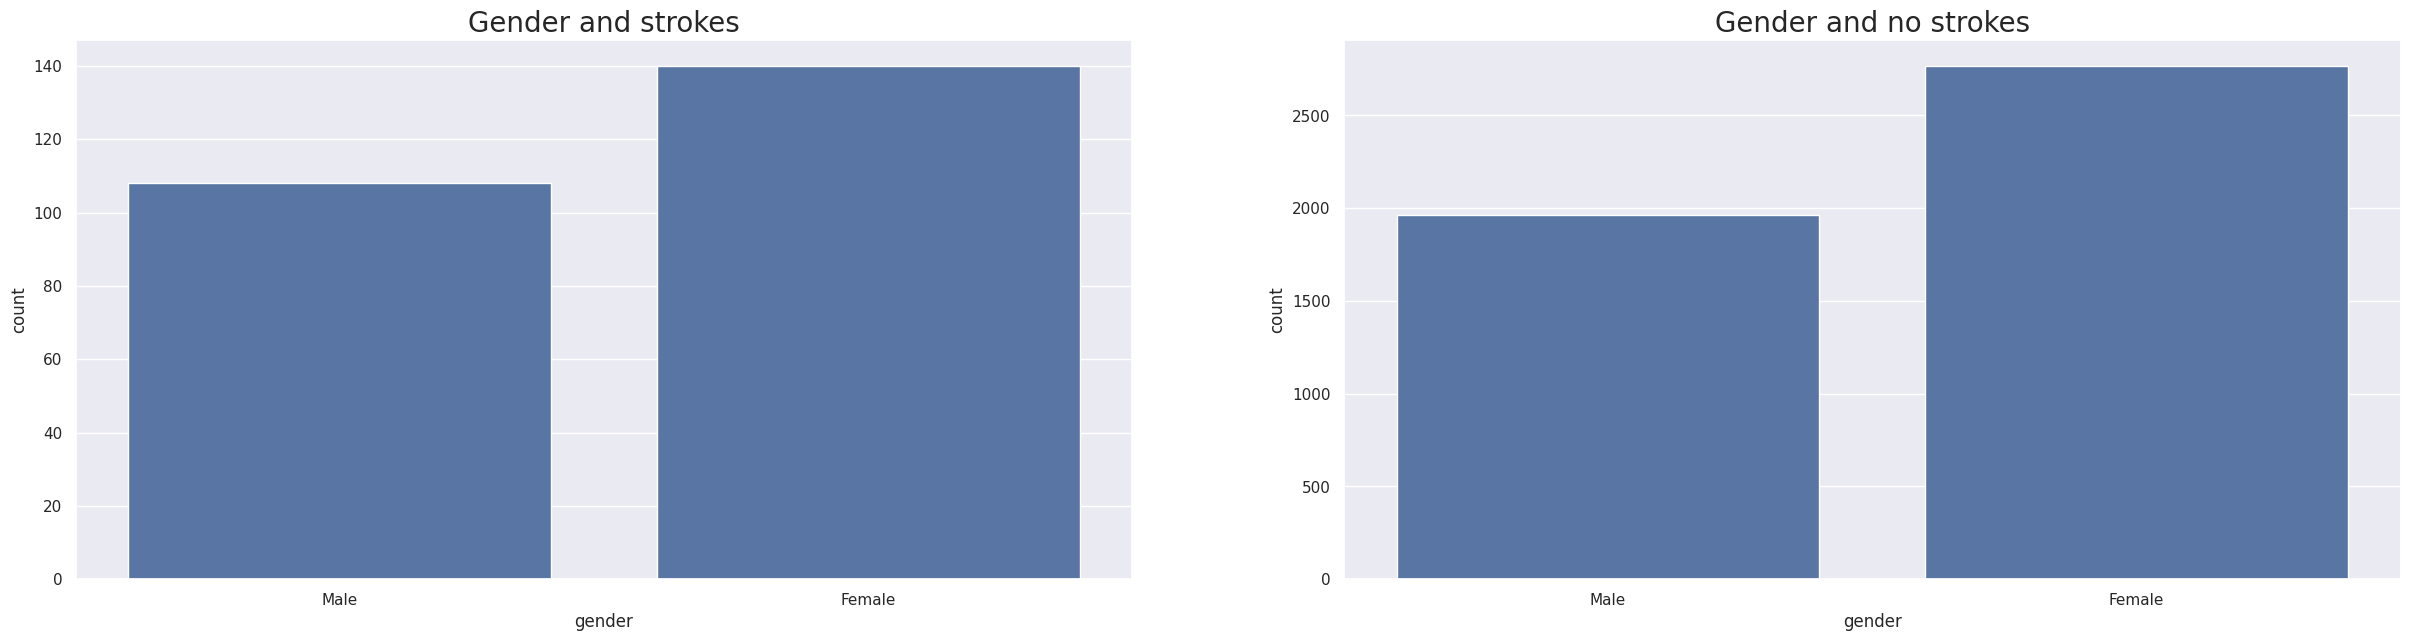

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(30,7))

axes[0].set_title('Gender and strokes', fontsize=20)
sns.countplot(data=df_pd.loc[df_pd['stroke'] == 'Stroke'], x='gender', ax=axes[0])

axes[1].set_title('Gender and no strokes', fontsize=20)
sns.countplot(data=df_pd.loc[df_pd['stroke'] == 'No stroke'], x='gender', ax=axes[1])

<Axes: title={'center': 'Hypertension and no strokes'}, xlabel='hypertension', ylabel='count'>

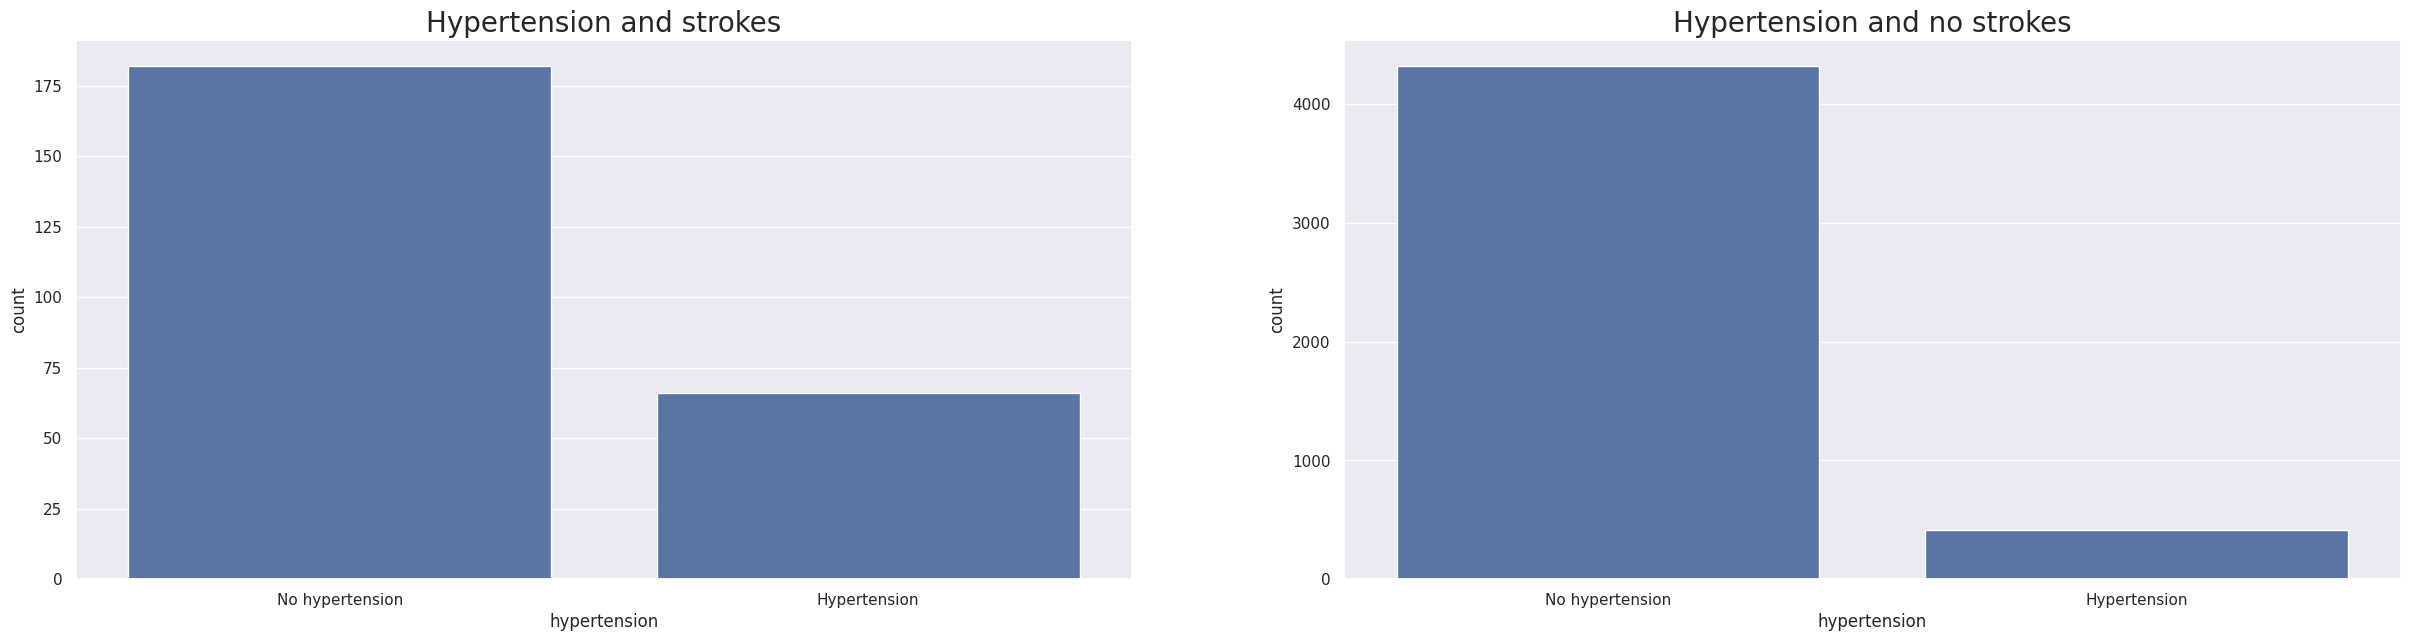

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(30,7))

axes[0].set_title('Hypertension and strokes', fontsize=20)
sns.countplot(data=df_pd.loc[df_pd['stroke'] == 'Stroke'], x='hypertension', ax=axes[0])

axes[1].set_title('Hypertension and no strokes', fontsize=20)
sns.countplot(data=df_pd.loc[df_pd['stroke'] == 'No stroke'], x='hypertension', ax=axes[1])

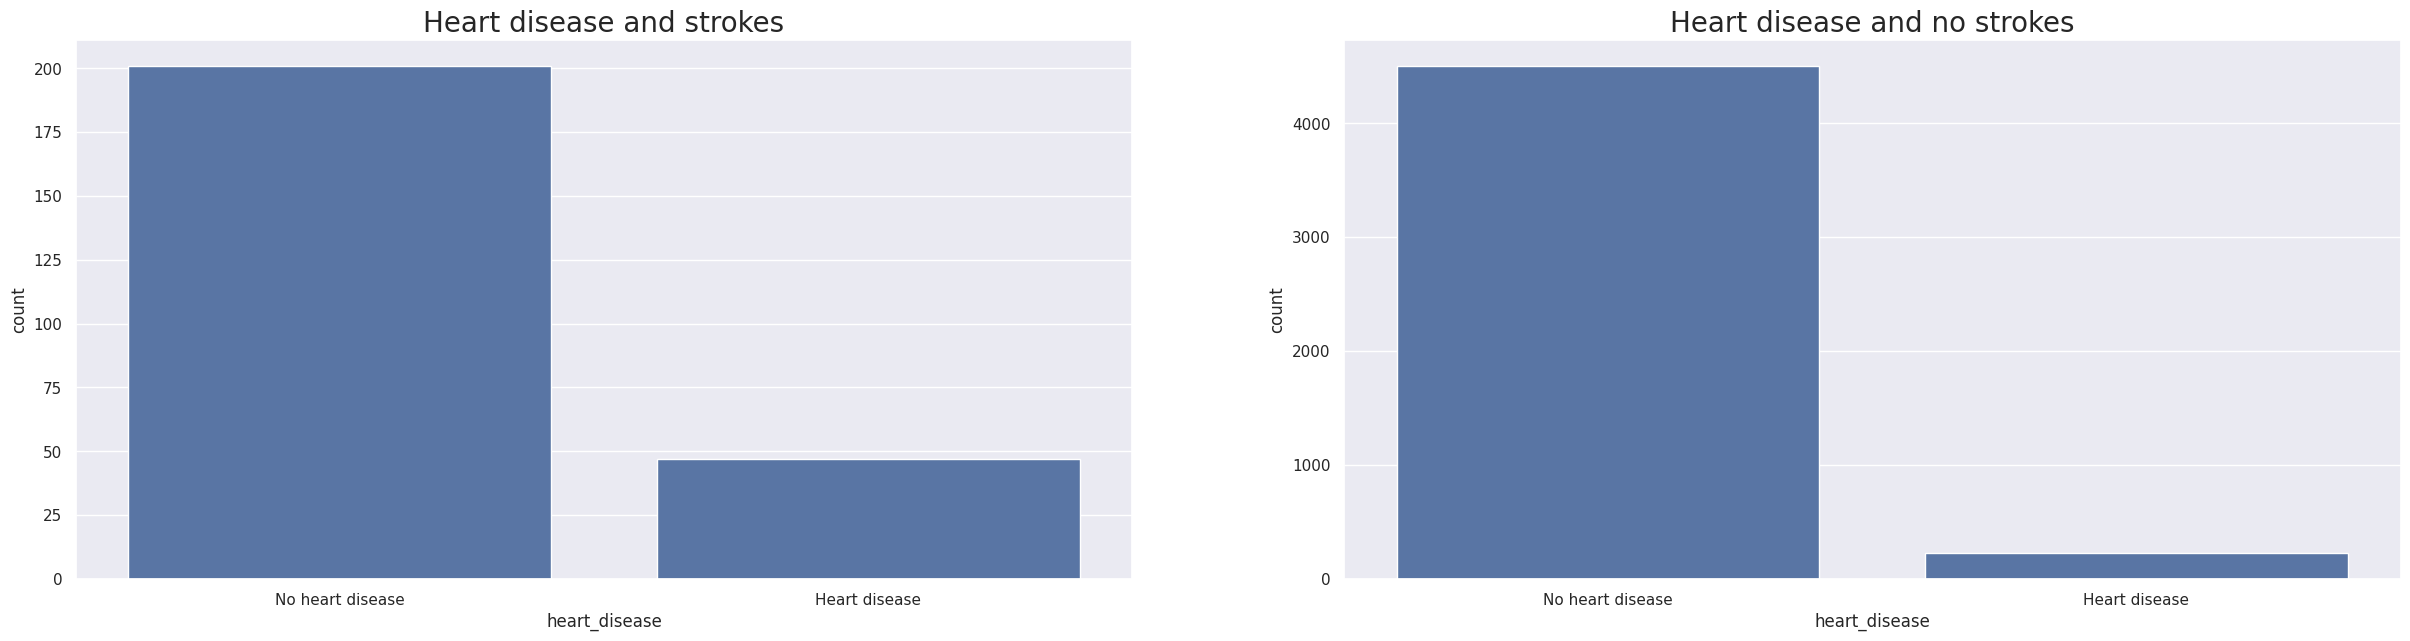

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(30,7))

axes[0].set_title('Heart disease and strokes', fontsize=20)
ax0 = sns.countplot(data=df_pd.loc[df_pd['stroke'] == 'Stroke'], x='heart_disease', order=['No heart disease', 'Heart disease'], ax=axes[0])

axes[1].set_title('Heart disease and no strokes', fontsize=20)
ax1 = sns.countplot(data=df_pd.loc[df_pd['stroke'] == 'No stroke'], x='heart_disease', ax=axes[1])

In [23]:
categorical = ('gender', 'ever_married', 'work_type', 'residence_type', 'smoking_status')

# Convert string data to numerical

In [24]:
indexer = StringIndexer(inputCol='gender', outputCol='gender_vec')
df_indexed = indexer.fit(df).transform(df)

indexer2 = StringIndexer(inputCol='ever_married', outputCol='married_vec')
df_indexed2 = indexer2.fit(df_indexed).transform(df_indexed)

indexer3 = StringIndexer(inputCol='work_type', outputCol='work_vec')
df_indexed3 = indexer3.fit(df_indexed2).transform(df_indexed2)

indexer4 = StringIndexer(inputCol='Residence_type', outputCol='residence_vec')
df_indexed4 = indexer4.fit(df_indexed3).transform(df_indexed3)

indexer5 = StringIndexer(inputCol='smoking_status', outputCol='smoking_vec')
df_indexed5 = indexer5.fit(df_indexed4).transform(df_indexed4)

df = df_indexed5.drop(*categorical)
df.show(3)

+----+------------+-------------+-----------------+----+------+---------+----------+-----------+--------+-------------+-----------+
| age|hypertension|heart_disease|avg_glucose_level| bmi|stroke|high_risk|gender_vec|married_vec|work_vec|residence_vec|smoking_vec|
+----+------------+-------------+-----------------+----+------+---------+----------+-----------+--------+-------------+-----------+
|67.0|           0|            1|           228.69|36.6|     1|        0|       1.0|        0.0|     0.0|          0.0|        2.0|
|80.0|           0|            1|           105.92|32.5|     1|        1|       1.0|        0.0|     0.0|          1.0|        0.0|
|49.0|           0|            0|           171.23|34.4|     1|        0|       0.0|        0.0|     0.0|          0.0|        3.0|
+----+------------+-------------+-----------------+----+------+---------+----------+-----------+--------+-------------+-----------+
only showing top 3 rows



In [25]:
feature = VectorAssembler(inputCols = df.drop('stroke').columns, outputCol='features')
feature_vector = feature.transform(df)
feature_vector.show(3)

+----+------------+-------------+-----------------+----+------+---------+----------+-----------+--------+-------------+-----------+--------------------+
| age|hypertension|heart_disease|avg_glucose_level| bmi|stroke|high_risk|gender_vec|married_vec|work_vec|residence_vec|smoking_vec|            features|
+----+------------+-------------+-----------------+----+------+---------+----------+-----------+--------+-------------+-----------+--------------------+
|67.0|           0|            1|           228.69|36.6|     1|        0|       1.0|        0.0|     0.0|          0.0|        2.0|(11,[0,2,3,4,6,10...|
|80.0|           0|            1|           105.92|32.5|     1|        1|       1.0|        0.0|     0.0|          1.0|        0.0|[80.0,0.0,1.0,105...|
|49.0|           0|            0|           171.23|34.4|     1|        0|       0.0|        0.0|     0.0|          0.0|        3.0|(11,[0,3,4,10],[4...|
+----+------------+-------------+-----------------+----+------+---------+---------

In [26]:
ml_df = feature_vector.select(['features', 'stroke'])
train, test = ml_df.randomSplit([0.8, 0.2])

# Logistic Regression

In [27]:
lr = LogisticRegression(labelCol='stroke')

paramGrid = ParamGridBuilder().addGrid(lr. regParam, (0.01, 0.1))\
                              .addGrid(lr.maxIter, (5, 10))\
                              .addGrid(lr.tol, (1e-4, 1e-5))\
                              .addGrid(lr.elasticNetParam, (0.25, 0.75))\
                              .build()

tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid,
                           evaluator=MulticlassClassificationEvaluator(labelCol='stroke'),
                           trainRatio=0.8)

lr_model = tvs.fit(train)
lr_model_pred = lr_model.transform(test)

In [28]:
results = lr_model_pred.select(['probability', 'stroke'])

results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)

metrics = metric(scoreAndLabels)
lr_acc = round(MulticlassClassificationEvaluator(labelCol='stroke', metricName='accuracy').evaluate(lr_model_pred), 4)
lr_prec = round(MulticlassClassificationEvaluator(labelCol='stroke', metricName='weightedPrecision').evaluate(lr_model_pred), 4)
lr_roc = round(metrics.areaUnderROC, 4)

lr_dict = {'Accuracy': lr_acc, 'Precision': lr_prec, 'ROC Score': lr_roc}

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


# Random Forest

In [29]:
rf = RandomForestClassifier(labelCol='stroke')

paramGrid = ParamGridBuilder().addGrid(rf.maxDepth, [5, 10, 20])\
                              .addGrid(rf.maxBins, [20, 32, 50])\
                              .addGrid(rf.numTrees, [20, 40, 60])\
                              .addGrid(rf.impurity, ['gini', 'entropy'])\
                              .addGrid(rf.minInstancesPerNode, [1, 5, 10])\
                              .build()

tvs = TrainValidationSplit(estimator=rf,
                           estimatorParamMaps=paramGrid,
                           evaluator=MulticlassClassificationEvaluator(labelCol='stroke'),
                           trainRatio=0.8)

rf_model = tvs.fit(train)
rf_model_pred = rf_model.transform(test)

In [30]:
results = rf_model_pred.select(['probability', 'stroke'])

results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)

metrics = metric(scoreAndLabels)
rf_acc = round(MulticlassClassificationEvaluator(labelCol='stroke', metricName='accuracy').evaluate(rf_model_pred), 4)
rf_prec = round(MulticlassClassificationEvaluator(labelCol='stroke', metricName='weightedPrecision').evaluate(rf_model_pred), 4)
rf_roc = round(metrics.areaUnderROC, 4)

rf_dict = {'Accuracy': rf_acc, 'Precision': rf_prec, 'ROC Score': rf_roc}

In [32]:
dicts = [lr_dict, rf_dict]
results = pd.DataFrame(dicts)
results['Models'] = ['Logistic Regression', 'Random Forest']
results.set_index(['Models'])

,Accuracy,Precision,ROC Score
Models,,,
Logistic Regression,0.9498,0.9021,0.8298
Random Forest,0.9448,0.9099,0.7640
